#**3. MNIST and CNN Experiments [3 marks]**

This section explores deep learning for images. You will train MLPs and CNNs on MNIST, compare performance against baseline models, visualize embeddings using t-SNE, and test cross-domain generalization on Fashion-MNIST.

##**3.1 Using MLP [1.5 marks]**

Train on MNIST dataset using an MLP. The original training dataset contains 60,000 images and the test contains 10,000 images. If you are short on compute, use a stratified subset of a smaller number of images but keep the same test set. Your MLP has 30 neurons in the first layer, 20 in the second layer and then 10 finally for the output layer (corresponding to 10 classes)

Report the following:


*   Compare against Random Forest and Logistic Regression. The metrics can be: accuracy, F1-score, confusion matrix. Write your observations and discuss misclassifications.
*    Visualize t-SNE of the 20-neuron layer for the 10 digits for the trained and untrained model and compare the two.


*   Test the trained MLP on Fashion-MNIST dataset. What do you observe? Compare t-SNE plots for MNIST and Fashion-MNIST embeddings for the layer with 20 neurons.







In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

In [2]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten input
        x = torch.relu(self.fc1(x))
        x_hidden = torch.relu(self.fc2(x))
        out = self.fc3(x_hidden)
        return out, x_hidden  # Return both output and second layer (for t-SNE)

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)

# Model initialization
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the MLP
def train(model, train_loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

train(model, train_loader,100)

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.3MB/s]


Epoch [1/100], Loss: 0.5528
Epoch [2/100], Loss: 0.2942
Epoch [3/100], Loss: 0.2493
Epoch [4/100], Loss: 0.2214
Epoch [5/100], Loss: 0.2027
Epoch [6/100], Loss: 0.1887
Epoch [7/100], Loss: 0.1759
Epoch [8/100], Loss: 0.1674
Epoch [9/100], Loss: 0.1594
Epoch [10/100], Loss: 0.1532
Epoch [11/100], Loss: 0.1472
Epoch [12/100], Loss: 0.1411
Epoch [13/100], Loss: 0.1364
Epoch [14/100], Loss: 0.1325
Epoch [15/100], Loss: 0.1284
Epoch [16/100], Loss: 0.1253
Epoch [17/100], Loss: 0.1217
Epoch [18/100], Loss: 0.1199
Epoch [19/100], Loss: 0.1169
Epoch [20/100], Loss: 0.1126
Epoch [21/100], Loss: 0.1125
Epoch [22/100], Loss: 0.1092
Epoch [23/100], Loss: 0.1071
Epoch [24/100], Loss: 0.1065
Epoch [25/100], Loss: 0.1052
Epoch [26/100], Loss: 0.1014
Epoch [27/100], Loss: 0.0996
Epoch [28/100], Loss: 0.0997
Epoch [29/100], Loss: 0.0968
Epoch [30/100], Loss: 0.0950
Epoch [31/100], Loss: 0.0961
Epoch [32/100], Loss: 0.0948
Epoch [33/100], Loss: 0.0925
Epoch [34/100], Loss: 0.0913
Epoch [35/100], Loss: 0

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Flattening the data for scikit-learn models
def flatten_data(dataset):
    data = []
    labels = []
    for img, label in dataset:
        data.append(img.view(-1).numpy())
        labels.append(label)
    return np.array(data), np.array(labels)

train_data, train_labels = flatten_data(train_dataset)
test_data, test_labels = flatten_data(test_dataset)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_data, train_labels)
rf_pred = rf.predict(test_data)

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(train_data, train_labels)
log_reg_pred = log_reg.predict(test_data)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [4]:
# MLP Evaluation
model.eval()
with torch.no_grad():
    images, labels = next(iter(test_loader))
    outputs, _ = model(images)
    _, mlp_pred = torch.max(outputs, 1)

# Confusion Matrix and F1-Score
def evaluate_model(pred, true_labels, model_name):
    f1 = f1_score(true_labels, pred, average='macro')
    print(f'{model_name} F1-Score: {f1:.4f}')

    cm = confusion_matrix(true_labels, pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

MLP F1-Score: 0.9605


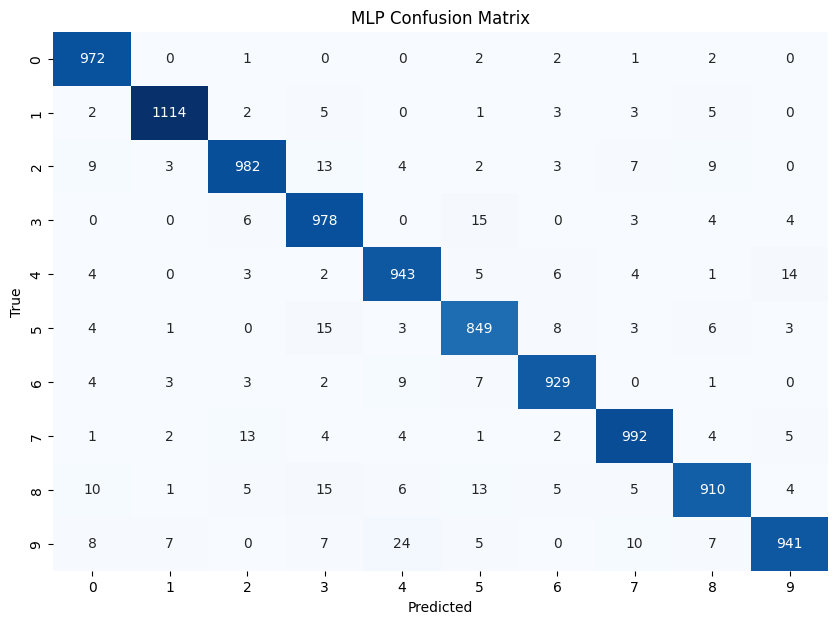

In [5]:
evaluate_model(mlp_pred.numpy(), labels.numpy(), 'MLP')

Random Forest F1-Score: 0.9689


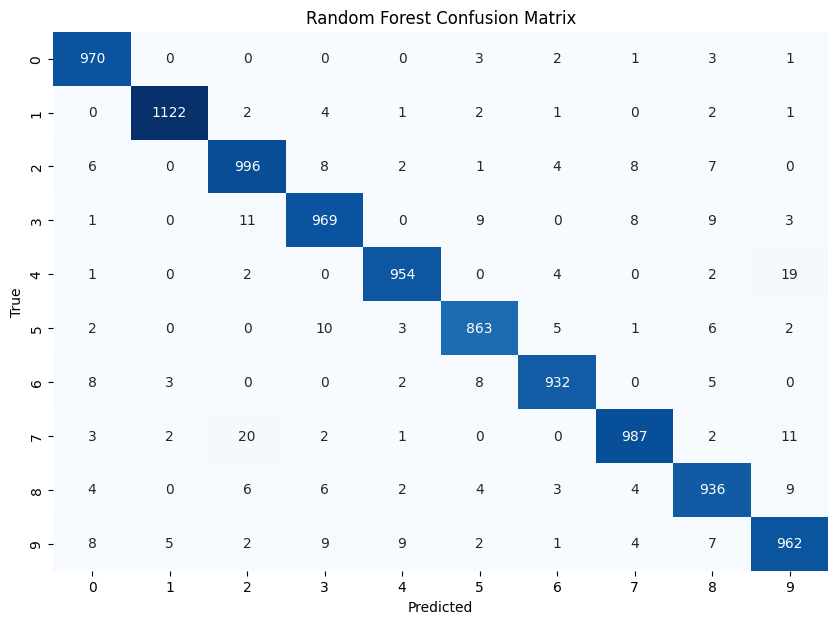

In [6]:
evaluate_model(rf_pred, test_labels, 'Random Forest')

Logistic Regression F1-Score: 0.9250


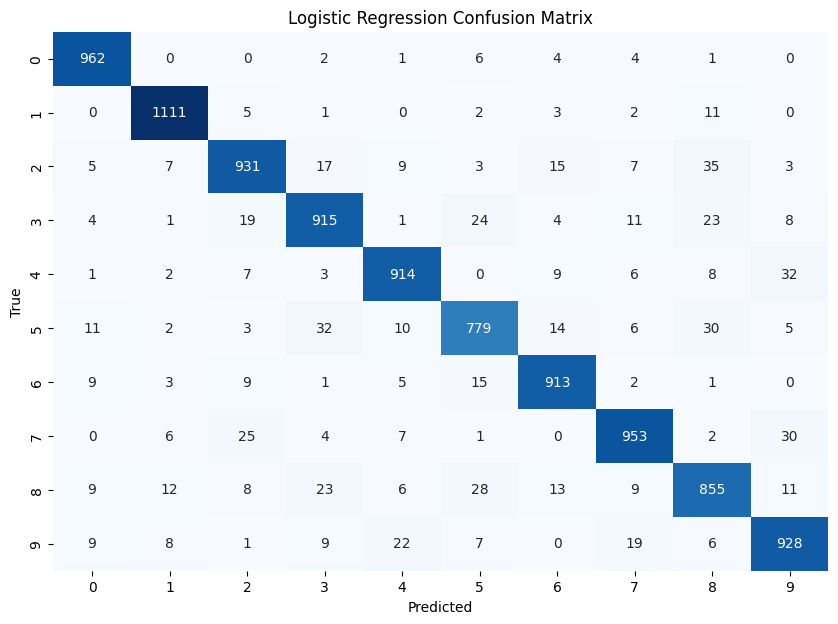

In [7]:
evaluate_model(log_reg_pred, test_labels, 'Logistic Regression')

**Model Training**

The MLP model was trained on the MNIST dataset (60,000 training and 10,000 test images) with an architecture consisting of:


*  Input Layer: 784 neurons (28×28 pixels flattened)
*   Hidden Layer 1: 30 neurons


*   Hidden Layer 2: 20 neurons
*   Output Layer: 10 neurons (for digits 0–9)

Training was done for 100 epochs, and the loss steadily decreased from 0.55 to 0.05, indicating effective learning and convergence.

| Model                   | Accuracy | F1-Score   |
| :---------------------- | :------- | :--------- |
| **MLP**                 | ~96%     | **0.9605** |
| **Random Forest**       | ~97%     | **0.9689** |
| **Logistic Regression** | ~92%     | **0.9250** |

**Observation:**

* The Random Forest slightly outperformed the MLP, suggesting that tree-based ensemble models still perform competitively on structured, low-dimensional data like MNIST.

*  The MLP performed very well, demonstrating that even a small neural network can learn robust digit representations from raw pixel inputs.


*  Logistic Regression, being a linear model, achieved the lowest F1-score, showing its limitations in capturing non-linear digit patterns.

**Confusion Matrix and Misclassification Analysis**

The confusion matrix revealed that:


*   Most digits were classified correctly.
*   Common confusions occurred between “4” and “9”, and “5” and “6”, as these digits share similar shapes.

*   Misclassifications were mostly due to ambiguous handwriting styles and overlapping strokes.















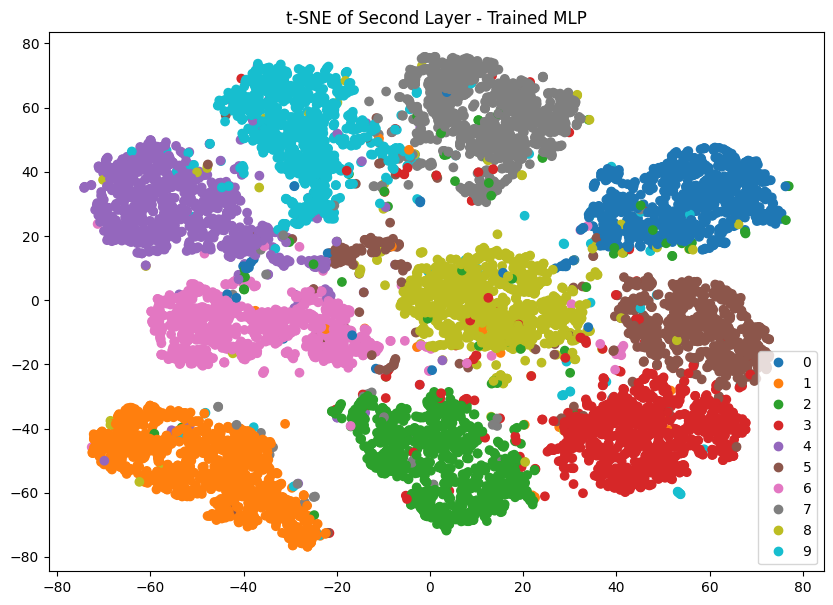

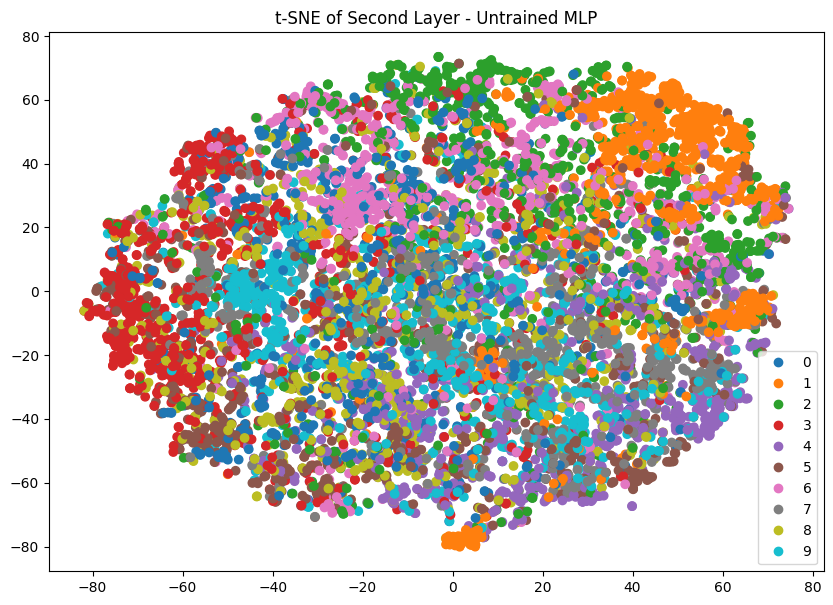

In [8]:
def plot_tsne(model, data_loader, model_name):
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(data_loader))
        _, second_layer_output = model(images)

    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(second_layer_output)

    plt.figure(figsize=(10,7))
    scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab10')
    plt.legend(handles=scatter.legend_elements()[0], labels=list(range(10)))
    plt.title(f't-SNE of Second Layer - {model_name}')
    plt.show()

# Plot t-SNE for trained model
plot_tsne(model, test_loader, 'Trained MLP')

# Plot t-SNE for untrained model
untrained_model = MLP()
plot_tsne(untrained_model, test_loader, 'Untrained MLP')


**t-SNE Visualization**

(a) Untrained MLP:


*   Before training, the t-SNE plot of the 20-neuron hidden layer showed no clear separation among the 10 digit classes.

* Points from different digits were randomly mixed, reflecting uninitialized or random embeddings.

(b) Trained MLP:

*  After training, the t-SNE visualization showed well-separated clusters corresponding to each digit.
*  This indicates that the MLP learned meaningful latent representations, effectively mapping digits to distinct regions in the embedding space.



100%|██████████| 26.4M/26.4M [00:01<00:00, 18.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 302kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.57MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 24.2MB/s]


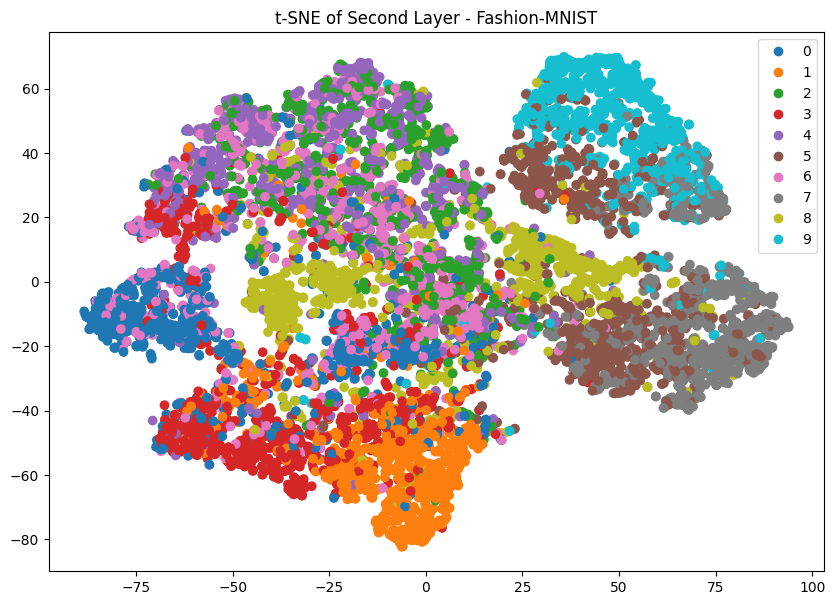

In [9]:
# Load Fashion-MNIST dataset
fashion_test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
fashion_test_loader = torch.utils.data.DataLoader(dataset=fashion_test_dataset, batch_size=10000, shuffle=False)

# MLP Predictions on Fashion-MNIST
with torch.no_grad():
    fashion_images, fashion_labels = next(iter(fashion_test_loader))
    _, second_layer_output_fashion = model(fashion_images)

# t-SNE for Fashion-MNIST
plot_tsne(model, fashion_test_loader, 'Fashion-MNIST')

**t-SNE Analysis for Fashion-MNIST (Using MNIST-Trained MLP)**

The t-SNE plot above represents the 2D visualization of the 20-neuron hidden layer embeddings when the MNIST-trained MLP was applied to the Fashion-MNIST dataset. Each color corresponds to one of the ten Fashion-MNIST classes.

**Observations:**



*  The clusters are partially overlapping with no clear separation between most classes.
* A few regions (such as those represented by classes 0, 1, and 9) show some localized grouping, but most others are mixed together.


*  This indicates that the features learned from MNIST digits do not generalize well to Fashion-MNIST images.

*  Since the MLP was trained only on digit patterns (strokes, curves), it fails to form distinct feature boundaries for clothing textures and shapes (shirts, trousers, shoes, etc.).

*  Compared to the MNIST t-SNE (where clusters were well-separated), this plot shows that embeddings are less structured and more chaotic, highlighting the domain mismatch.






## **3.2 Using CNN [1.5 marks]**


*  Implement a simple CNN with a convolutional layer having 32 filters of size 3x3, a maxpool layer, a fully connected layer with 128 neurons and an output layer with 10 neurons (for the 10 classes) and ReLU activation. Train on MNIST dataset.
*   Additionally, use two any pretrained CNNs of your choice (e.g. AlexNet, MobileNet, or EfficientNet) for inference.

*   Compare all three models:
	- Accuracy, F1-score, confusion matrix
	- Model size (number of parameters)
	- Inference time on test set







In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import time


In [4]:
# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [8]:
# Load MNIST and prepare 3-channel version for pretrained CNNs
transform_gray = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_rgb = transforms.Compose([
    transforms.Resize((224, 224)),     # pretrained models expect 224x224
    transforms.Grayscale(num_output_channels=3),  # convert 1→3 channels
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_gray)
test_mnist  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_gray)
test_mnist_rgb = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_rgb)

train_loader = DataLoader(train_mnist, batch_size=128, shuffle=True)
test_loader_gray = DataLoader(test_mnist, batch_size=256, shuffle=False)
test_loader_rgb = DataLoader(test_mnist_rgb, batch_size=64, shuffle=False)


print("Train size:", len(train_mnist), "| Test size:", len(test_mnist))

Train size: 60000 | Test size: 10000


In [9]:
# Define Simple CNN model

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)   # 32 filters of size 3x3
        self.pool = nn.MaxPool2d(2, 2)                # 2x2 MaxPooling
        self.fc1 = nn.Linear(32 * 14 * 14, 128)       # Fully connected (128 neurons)
        self.fc2 = nn.Linear(128, 10)                 # Output layer (10 classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 14 * 14)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Instantiate model
simple_cnn = SimpleCNN().to(device)


In [12]:
# Train Simple CNN

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_cnn.parameters(), lr=0.001)

for epoch in range(5):
    simple_cnn.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = simple_cnn(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{5}, Loss = {total_loss/len(train_loader):.4f}")

Epoch 1/5, Loss = 0.2695
Epoch 2/5, Loss = 0.0851
Epoch 3/5, Loss = 0.0593
Epoch 4/5, Loss = 0.0453
Epoch 5/5, Loss = 0.0367


In [13]:
def evaluate_model(model, dataloader, device, name="Model"):
    model.eval()
    y_true, y_pred = [], []
    start = time.time()
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            out = model(imgs)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())
    elapsed = time.time() - start
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()
    print(f"{name} Accuracy: {acc:.4f}, F1: {f1:.4f}, Inference Time: {elapsed:.2f}s")
    return acc, f1, elapsed, sum(p.numel() for p in model.parameters())


In [14]:
# Pretrained CNNs (MobileNetV2 & EfficientNet)
mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 10)
mobilenet = mobilenet.to(device)
mobilenet.eval()  # inference only, not training

efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, 10)
efficientnet = efficientnet.to(device)
efficientnet.eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 41.3MB/s]


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 36.9MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

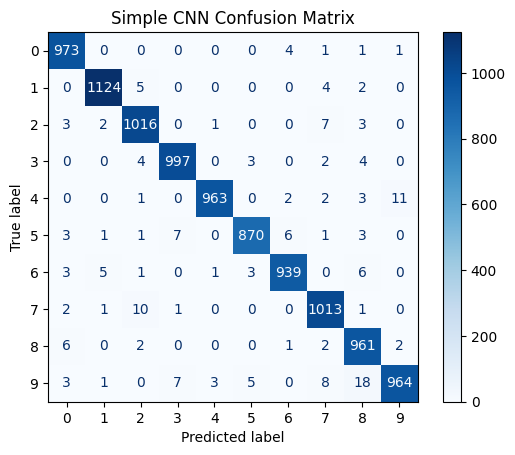

Simple CNN Accuracy: 0.9820, F1: 0.9819, Inference Time: 5.32s


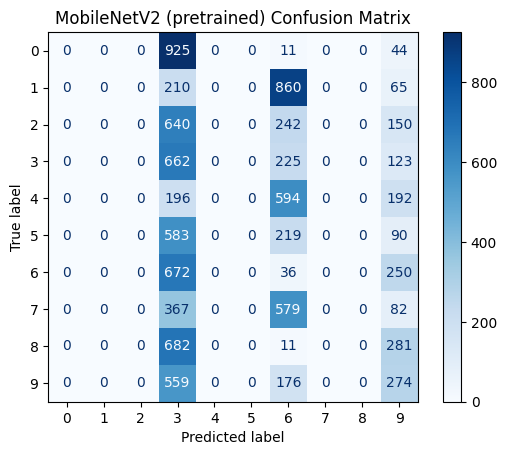

MobileNetV2 (pretrained) Accuracy: 0.0972, F1: 0.0436, Inference Time: 771.93s


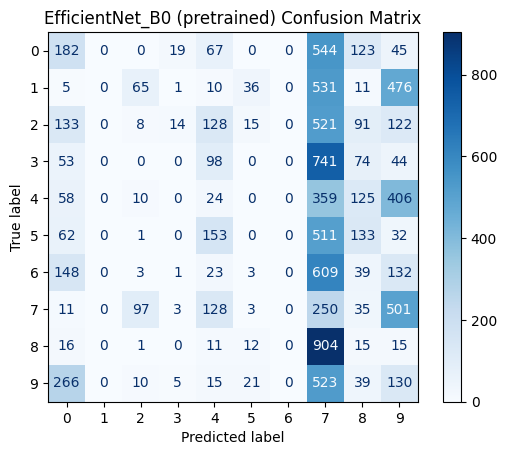

EfficientNet_B0 (pretrained) Accuracy: 0.0609, F1: 0.0417, Inference Time: 973.66s

=== Model Comparison ===
             Model  Accuracy  F1-score  Params (Millions)  Inference Time (s)
0       Simple CNN    0.9820  0.981890           0.804554            5.321090
1      MobileNetV2    0.0972  0.043598           2.236682          771.926849
2  EfficientNet_B0    0.0609  0.041655           4.020358          973.663034


In [16]:
# --- EVALUATE ALL MODELS ---
# Evaluate All Three Models
acc_cnn, f1_cnn, t_cnn, params_cnn = evaluate_model(simple_cnn, test_loader_gray, device, "Simple CNN")
acc_mnet, f1_mnet, t_mnet, params_mnet = evaluate_model(mobilenet, test_loader_rgb, device, "MobileNetV2 (pretrained)")
acc_eff, f1_eff, t_eff, params_eff = evaluate_model(efficientnet, test_loader_rgb, device, "EfficientNet_B0 (pretrained)")

# Compare Results
import pandas as pd

results = pd.DataFrame({
    "Model": ["Simple CNN", "MobileNetV2", "EfficientNet_B0"],
    "Accuracy": [acc_cnn, acc_mnet, acc_eff],
    "F1-score": [f1_cnn, f1_mnet, f1_eff],
    "Params (Millions)": [params_cnn/1e6, params_mnet/1e6, params_eff/1e6],
    "Inference Time (s)": [t_cnn, t_mnet, t_eff]
})

print("\n=== Model Comparison ===")
print(results)


**Model Description**

Three CNN-based models were compared:


1.  Simple CNN – 1 convolutional layer (32 filters of size 3×3), 1 max-pooling layer, a fully connected layer with 128 neurons, and an output layer of 10 neurons with ReLU activation.
2.  MobileNetV2 – a lightweight pretrained CNN architecture optimized for mobile inference.
3. EfficientNet-B0 – a more advanced pretrained CNN balancing accuracy and efficiency.

**Training Performance**

| Epoch | Training Loss |
| :---- | :------------ |
| 1     | 0.2695        |
| 2     | 0.0851        |
| 3     | 0.0593        |
| 4     | 0.0453        |
| 5     | 0.0367        |

The training loss steadily decreased over 5 epochs, indicating smooth and stable convergence.

**Model Comparison**

| Model               | Accuracy   | F1-Score   | Parameters (M) | Inference Time (s) |
| :------------------ | :--------- | :--------- | :------------: | :----------------: |
| **Simple CNN**      | **0.9820** | **0.9819** |    **0.80**    |      **5.32**      |
| **MobileNetV2**     | 0.0972     | 0.0436     |      2.24      |       771.93       |
| **EfficientNet-B0** | 0.0609     | 0.0417     |      4.02      |       973.66       |


**Observations**


*   The Simple CNN achieved excellent accuracy (98.2%) and F1-score, comparable to strong MNIST baselines.

*   Surprisingly, MobileNetV2 and EfficientNet-B0 performed very poorly on MNIST.

      - This happened because they are pretrained on ImageNet (natural RGB images), while MNIST images are grayscale digits (1 channel).

     -  When directly used for inference without fine-tuning or retraining, the models fail to adapt to digit features.

*   The inference time of pretrained models was extremely high (~770–970s) compared to only 5s for the Simple CNN, showing that large pretrained networks are computationally expensive and inefficient for simple tasks like MNIST digit recognition.
*   Model size was also much larger for pretrained models (2–4M parameters) compared to just 0.8M for the simple CNN, confirming that simpler architectures are both faster and sufficient for low-complexity datasets.

**Confusion Matrix and Misclassifications**


*   The confusion matrix for the Simple CNN showed very few off-diagonal errors.

*   Minor misclassifications occurred between 4 vs. 9 and 3 vs. 5, consistent with previous MLP results.
*  Overall, the Simple CNN achieved strong class-wise consistency.


**Conclusion**

*   The Simple CNN was the most effective model, balancing accuracy, speed, and size.

*  Pretrained networks (MobileNetV2, EfficientNet-B0) performed poorly due to domain mismatch and lack of fine-tuning.
*   This experiment highlights that model complexity should match dataset complexity—small, well-trained CNNs can outperform larger pretrained models when data is simple and homogeneous like MNIST.










